In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'markdown:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2483882%2F4216835%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240904%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240904T071904Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D11a4fd4523558f73c7eed5e2d6da492c04adbb751e40bae9a9ea6546b1c5ce882f04a83ad663bb734b45ba2dc0747cf20783b022ad8553440e1a1111a4789b3a03e5e60019ddd7ad96cd8da88a221f94c1681dd71cd645324e0c7fdf71efd1f22bd52701a4c1a8790da7eee899c534bb831b098938f21d2eb2a979c69cbcd6746a081bb76ed4726cae6badeb9a96fcc7c6d823869541920854478e34601f49c083725dbfbc9a3d7c8f016d3df320fb07fabdf4aa3281d81393845fc172bfe0b2b7fdce37bb4e2108863c2ae8905080debe12c5c3efdf0c6f414bfc6a7ab525f85f36a94ab3185ef8ac8d2d3b0882c2a6acc98e13bef13837a186be8e6dc68b73'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2310866 bytes downloaded
Downloaded and uncompressed: markdown
Data source import complete.


In [2]:
!pip install diffusers==0.3.0 --q
!pip install transformers scipy ftfy --q
!pip install "ipywidgets>=7,<8" --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 969.7 kB/s eta 0:00:00


In [3]:
import gc
import torch
from PIL import Image
import IPython.display
from torch import autocast
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import StableDiffusionPipeline
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers import LMSDiscreteScheduler , PNDMScheduler


from google.colab import userdata
Hugging_face=userdata.get('hugging_id')

In [4]:
class config :
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    HEIGHT = 512
    WIDTH = 512
    NUM_INFERENCE_STEPS = 500
    GUIDANCE_SCALE = 7.5
    GENERATOR = torch.manual_seed(48)
    BATCH_SIZE = 1

In [5]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [6]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_auth_token=Hugging_face)
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", use_auth_token=Hugging_face)
vae = vae.to(config.DEVICE)
text_encoder = text_encoder.to(config.DEVICE)
unet = unet.to(config.DEVICE)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/diffusers/modeling_utils.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location="cpu")


tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [7]:
print(f'\033[94mTokenizer, Text Encoder, VAE, Unet are loaded !!')

Tokenizer, Text Encoder, VAE, Unet are loaded !!


In [8]:
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
print(f'\033[94mThe scheduler loaded is K-LMS Sceheduler')

The scheduler loaded is K-LMS Sceheduler


In [9]:
prompt = ["a curious explorer discovers a massive sprawling underground city in a huge cave system. city has churches, european - style buildings and big towers, and is really far away, illuminated by dim ambient lighting. waterfalls are flowing between different levels of the city. award winning digital art, concept art, breathtaking, imaginative, detailed., 8k"]

In [10]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
max_length = text_input.input_ids.shape[-1]
with torch.no_grad():
      text_embeddings = text_encoder(text_input.input_ids.to(config.DEVICE))[0]
uncond_input = tokenizer(
    [""] * config.BATCH_SIZE, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
      uncond_embeddings = text_encoder(uncond_input.input_ids.to(config.DEVICE))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
print(f'\033[94mText Embeddings shape: {text_embeddings.shape}')

Text Embeddings shape: torch.Size([2, 77, 768])


In [11]:
latents = torch.randn(
  (config.BATCH_SIZE, unet.in_channels, config.HEIGHT // 8, config.WIDTH // 8),
  generator=config.GENERATOR,
)
latents = latents.to(config.DEVICE)

print(f'\033[94mLatent shape: {latents.shape}')

Latent shape: torch.Size([1, 4, 64, 64])


In [12]:
scheduler.set_timesteps(config.NUM_INFERENCE_STEPS)
latents = latents * scheduler.sigmas[0]

In [13]:
with autocast(config.DEVICE):
      for i, t in tqdm(enumerate(scheduler.timesteps)):

        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

        with torch.no_grad():
              noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + config.GUIDANCE_SCALE * (noise_pred_text - noise_pred_uncond)

        latents = scheduler.step(noise_pred, i, latents).prev_sample

0it [00:00, ?it/s]

In [14]:
latents = 1 / 0.18215 * latents

with torch.no_grad():
  image = vae.decode(latents).sample
print(f'\033[94mImage shape: {image.shape}')

Image shape: torch.Size([1, 3, 512, 512])


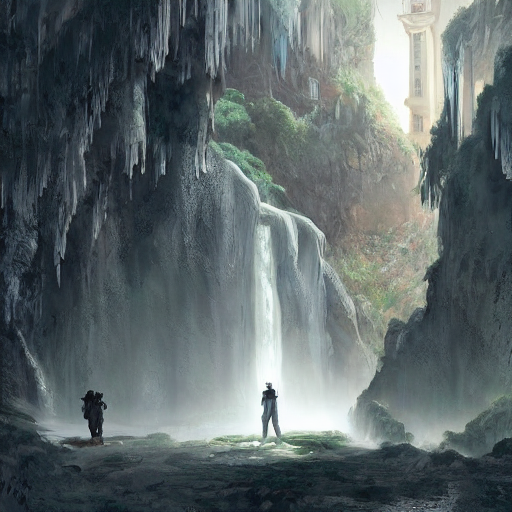

In [15]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]